In [156]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['text.usetex'] = True 


import yt
import numpy as np
from numpy import *
from astropy.table import Table, Column
from foggie.utils import yt_fields
import os, sys, argparse
from foggie.utils.consistency import *
import matplotlib.pyplot as plt
from foggie.utils.foggie_load import *



In [5]:
def parse_args(haloname, DDname):
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter,
                                     description='''identify satellites in FOGGIE simulations''')
    parser.add_argument('-system', '--system', metavar='system', type=str, action='store', \
                        help='Which system are you on? Default is Jase')
    parser.set_defaults(system="jase")
    
    parser.add_argument('--run', metavar='run', type=str, action='store',
                        help='which run? default is natural')
    parser.set_defaults(run="nref11c_nref9f")

    parser.add_argument('--halo', metavar='halo', type=str, action='store',
                        help='which halo? default is 8508 (Tempest)')
    parser.set_defaults(halo=haloname.strip('halo_00'))

    parser.add_argument('--pwd', dest='pwd', action='store_true',
                        help='just use the pwd?, default is no')
    parser.set_defaults(pwd=False)

    parser.add_argument('--run_all', dest='run_all', action='store_true',
                        help='just use the pwd?, default is no')
    parser.set_defaults(pwd=False)


    parser.add_argument('--output', metavar='output', type=str, action='store',
                        help='which output? default is RD0020')
    parser.set_defaults(output=DDname)


    args = parser.parse_args('')
    return args



In [6]:
haloname = 'halo_008508'
DDname = 'DD0487'
args = parse_args(haloname, DDname)
ds, refine_box = load_sim(args)


yt : [INFO     ] 2020-10-13 08:00:32,259 Parameters: current_time              = 154.8165043678
yt : [INFO     ] 2020-10-13 08:00:32,261 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2020-10-13 08:00:32,261 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-10-13 08:00:32,262 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-10-13 08:00:32,264 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-10-13 08:00:32,264 Parameters: current_redshift          = 1.9997938414155
yt : [INFO     ] 2020-10-13 08:00:32,265 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2020-10-13 08:00:32,266 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2020-10-13 08:00:32,267 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/rsimons/Desktop/foggie/sims/halo_008508/nref11c_nref9f/DD0487/DD0487


Parsing Hierarchy :   0%|          | 0/7623 [00:00<?, ?it/s]

get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.99979384142 0.493035 0.487894 0.501194 0.495035 0.489894 0.503194    9
Pulling halo center from catalog file


Parsing Hierarchy : 100%|██████████| 7623/7623 [00:00<00:00, 23722.23it/s]
yt : [INFO     ] 2020-10-13 08:00:33,269 Gathering a field list (this may take a moment.)


filtering young_stars particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...


In [11]:
def _velocity1d(field, data):
    bulk_velocity = data.get_field_parameter('bulk_velocity')
    return np.sqrt((data['gas', 'velocity_x'] - bulk_velocity[0])**2. + (data['gas', 'velocity_y'] - bulk_velocity[1])**2. + (data['gas', 'velocity_z'] -  - bulk_velocity[2])**2.)/(sqrt(3))
ds.add_field(("gas", "velocity_1d"), function=_velocity1d, units="km/s")


def _static_rampressure(field, data):
    vel = data['gas', 'velocity_1d']
    rp = data['density'] * vel**2.
    return np.log10(rp.to('dyne/cm**2'))


ds.add_field(("gas", "ram_pressure"), function=_static_rampressure, units = "")



/Users/rsimons/opt/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  after removing the cwd from sys.path.
yt : [WARNING  ] 2020-10-13 08:07:45,948 Field ('gas', 'ram_pressure') already exists. To override use force_override=True.
/Users/rsimons/opt/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  del sys.path[0]


In [122]:
import scipy
from scipy import interpolate
result = {}
for p in [2.1, 5, 16, 50, 84, 95, 99.7]:
    result[p] = []
result['rad'] = []


for in_sp_rad in np.arange(10, 81, 1):
    if in_sp_rad%10 == 0: print (in_sp_rad)
    out_sp_rad = in_sp_rad + 1
    in_sp      = ds.sphere(cen, (int(in_sp_rad), 'kpc'))
    out_sp     = ds.sphere(cen, (int(out_sp_rad), 'kpc'))
    sp = out_sp - in_sp
    sp.set_field_parameter('bulk_velocity', ds.halo_velocity_kms)
    rp  = sp["gas", "ram_pressure"]
    vol = sp["gas", "cell_volume"]
    
    rp_argsort = argsort(rp)
    
    rp_sort  = rp[rp_argsort]
    vol_sort = vol[rp_argsort]
    total_volume = np.sum(vol_sort)
    cumsum_volume = np.cumsum(vol_sort)/total_volume

    interp_volume = interpolate.interp1d(cumsum_volume, rp_sort)
    for p in [2.1, 5, 16, 50, 84, 95, 99.7]:
        result[p].append(float(interp_volume(p/100.)))
    result['rad'].append(in_sp_rad)


10
20
30
40
50
60
70
80


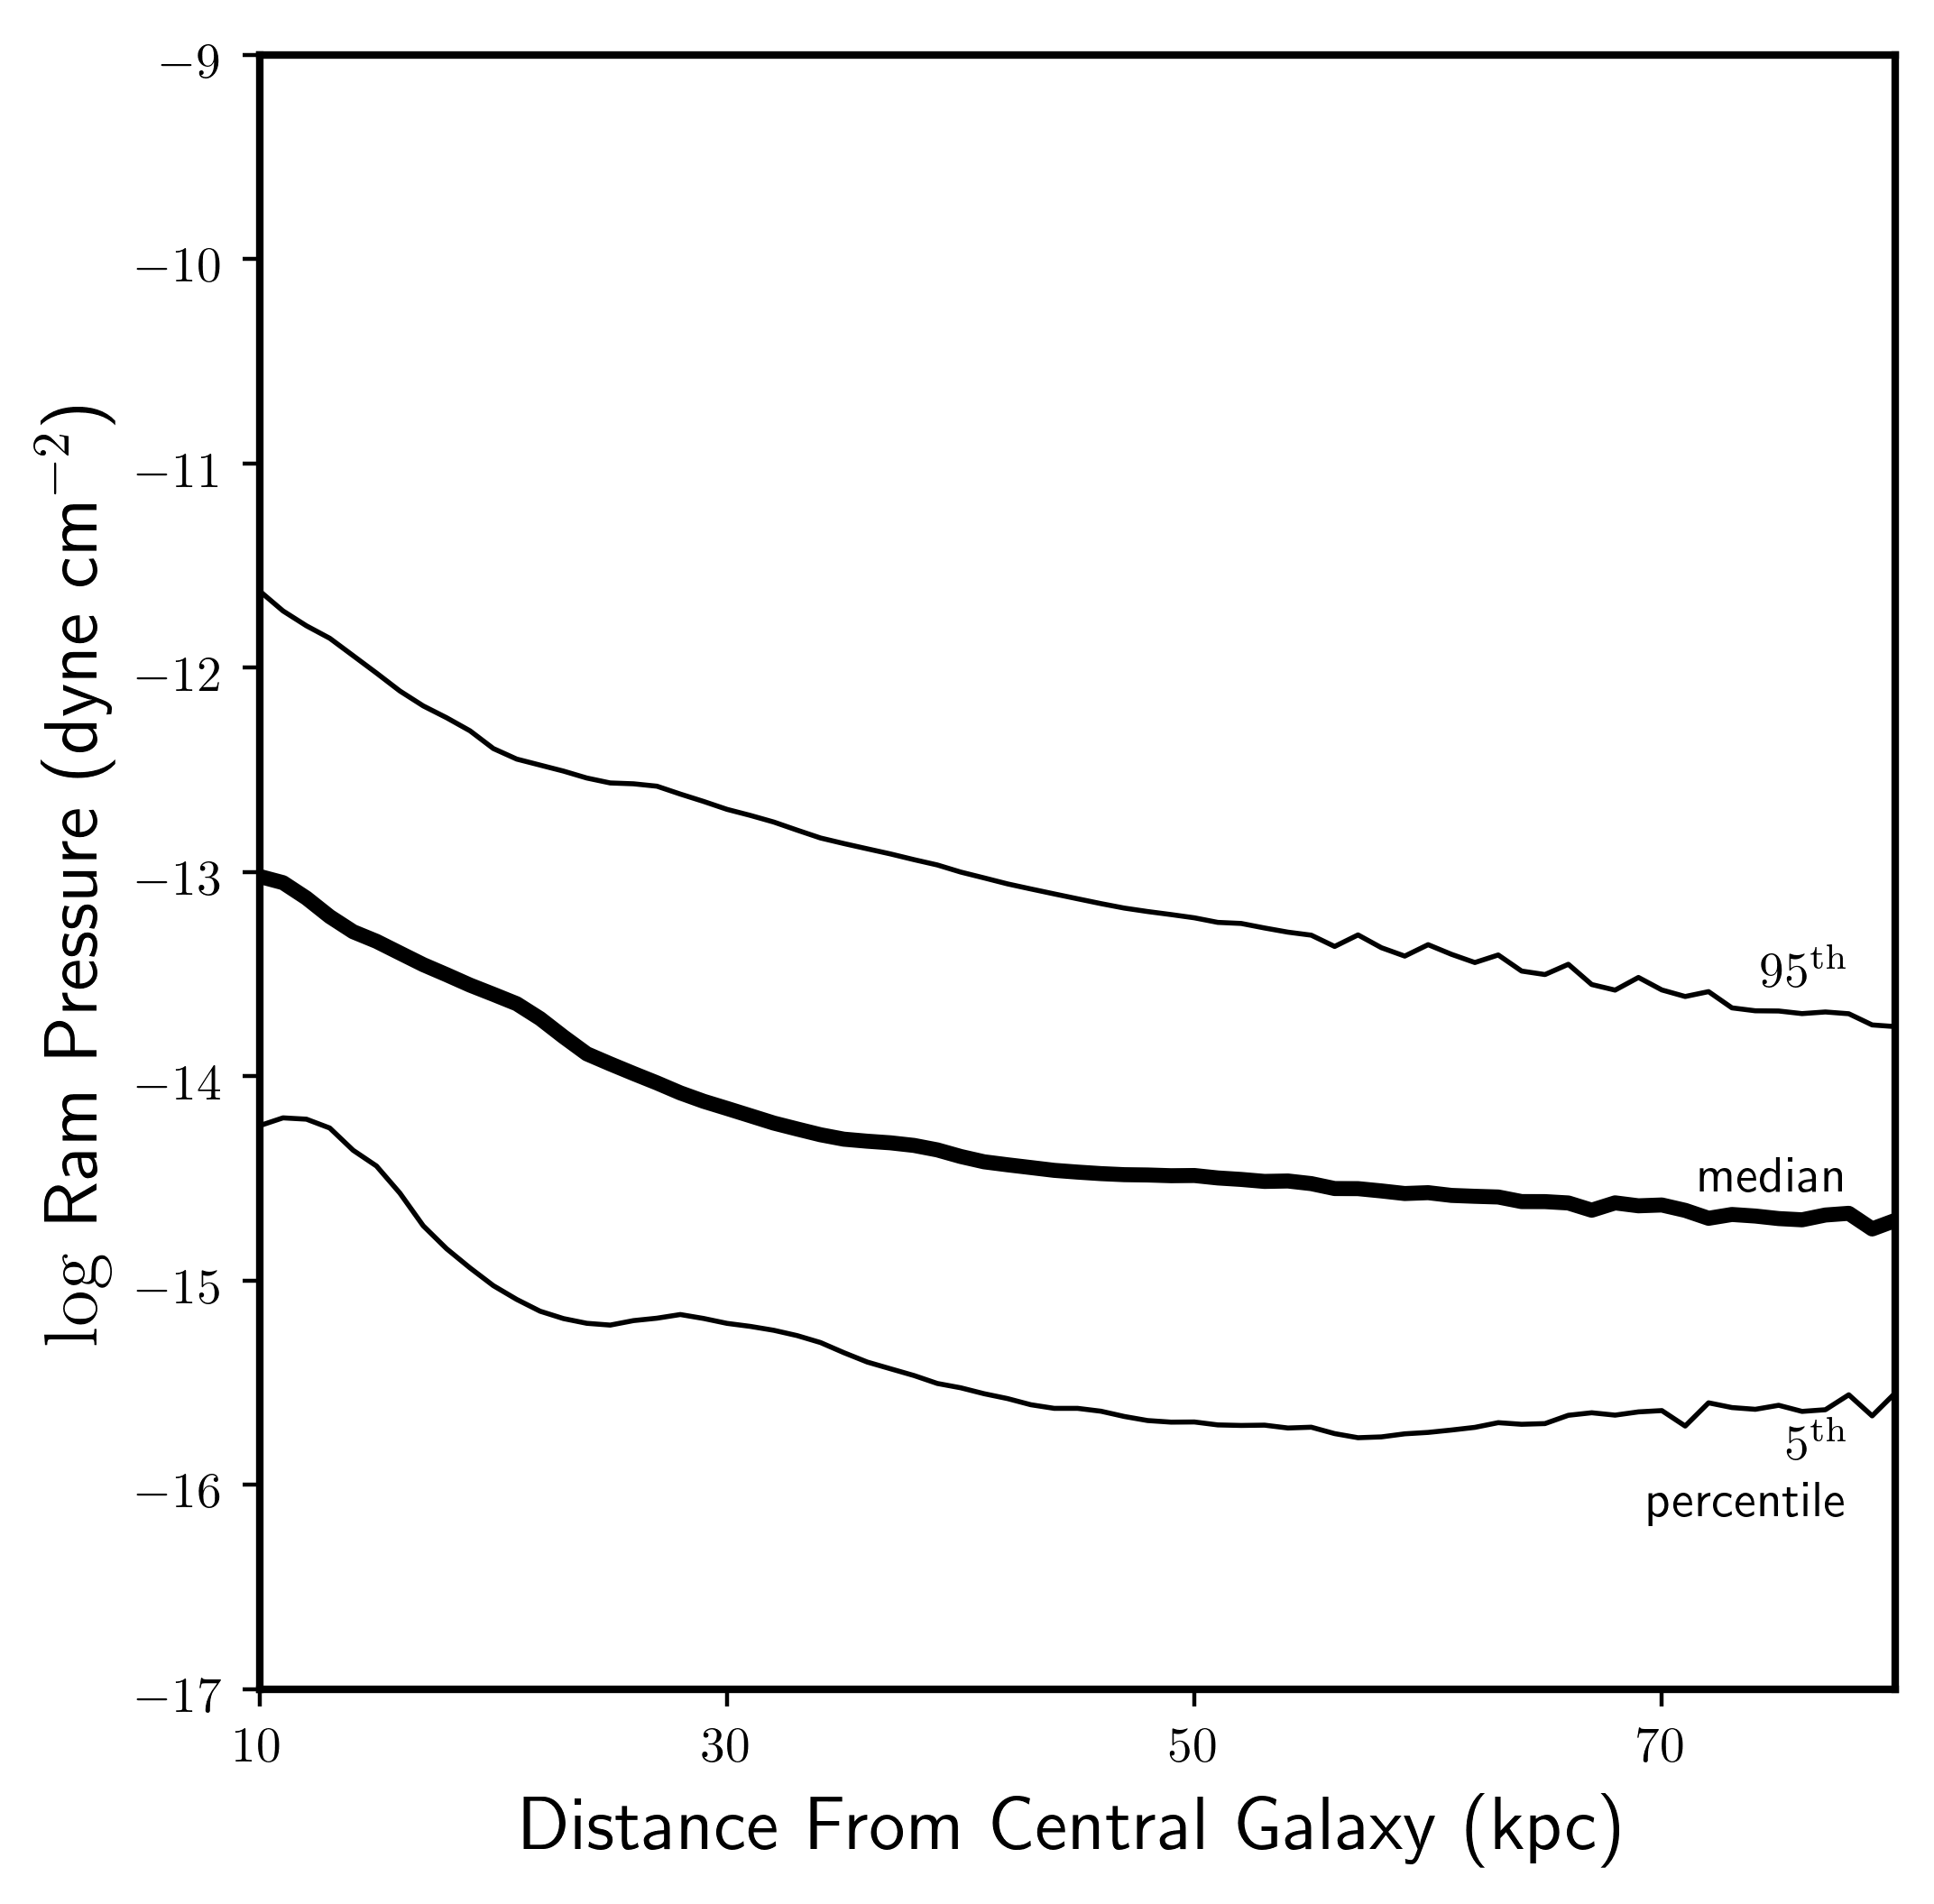

In [161]:
fig, ax = plt.subplots(1,1, figsize = (5.85,6))

#ax.plot(result['rad'], result[2.1], 'k--', linewidth = 1)
ax.plot(result['rad'], result[5], 'k-', linewidth = 1.)
#ax.plot(result['rad'], result[16], 'k--', linewidth = 1)
ax.plot(result['rad'], result[50], 'k-', linewidth = 3)
#ax.plot(result['rad'], result[84], 'k--', linewidth = 1)
ax.plot(result['rad'], result[95], 'k-', linewidth = 1.)
#ax.plot(result['rad'], result[99.7], 'k--', linewidth = 1)


ax.set_ylim(-17, -9)
ax.set_xlim(10, 80)
ax.set_xticks([10, 30, 50, 70])

ax.set_xlabel('Distance From Central Galaxy (kpc)')
ax.set_ylabel('$\log$ Ram Pressure (dyne cm$^{-2}$)')

ax.annotate('median', (78, -14.5), ha = 'right', va = 'center')
ax.annotate('$95^{\mathrm{th}}$', (78, -13.5), ha = 'right', va = 'center')
ax.annotate('$5^{\mathrm{th}}$' + '\npercentile', (78, -15.95), ha = 'right', va = 'center')

fig.set_dpi(400)
fig.savefig('/Users/rsimons/Dropbox/foggie/figures/for_paper/RP_radprofile_percentile_volume.png', transparent=True)

this ran fine


10 <class 'numpy.int64'>
11 <class 'numpy.int64'>


int

int